# Tweet Classification
 This Notebook will be our last step in the project. We'll use LLMs fine-tuned for sentiment analysis, hate speech detection, and argument detection.

 The models and statistcal tests are implemented in src/classification_models.py and src/stat_tests.py

In [1]:
import pandas as pd
from src.preprocess import load_clean_data
from src.classification_models import label_and_score_tweets
from src.stat_tests import chi_square_test, fishers_exact_test, pairwise_t_tests, paired_mannwhitneyu_rank_test
from src.plotting import barplot_multiple_dataframes, plot_correlation_heatmap, bar_plot_many_datapoints
from src.topic_modelling import generate_wordcloud

pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x) if pd.api.types.is_float_dtype(x) else x)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rafiqmazen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/rafiqmazen/anaconda3/envs/poli/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rafiqmazen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# first let's load our data
df = load_clean_data("preprocessed_data/clean_data.csv")

Unlike argument detection and sentiment analysis, hate speech is subjective and sometimes maybe biased. For that reason, we'll have to use three different models for hate detection and use majority vote to label a tweet either as hateful or not.

In [3]:
df["hate_label_1"], df["hate_score_1"] = label_and_score_tweets(
    model_id = "hate speech 1",
    tweets = df.tweets.to_list()
)

In [4]:
df["hate_label_2"], df["hate_score_2"] = label_and_score_tweets(
    model_id = "hate speech 2",
    tweets = df.tweets.to_list()
)

In [5]:
df["hate_label_3"], df["hate_score_3"] = label_and_score_tweets(
    model_id = "hate speech 3",
    tweets = df.tweets.to_list()
)

In [6]:
df["sentiment_label"], df["sentiment_score"] = label_and_score_tweets(
    model_id = "sentiment analysis",
    tweets = df.tweets.to_list()
)

In [7]:
df["argument_label"], df["argument_score"] = label_and_score_tweets(
    model_id = "argument detection",
    tweets = df.tweets.to_list()
)

In [8]:
#let's save our results since they take a long time to generate
df.to_csv("results.csv", sep ="|")

In [9]:
df = pd.read_csv("results.csv", sep = "|")

Inside classification_models.py, we transformed the output model labels labels so that a label of 1 is hate speech in the case of the three models and an "argument" in case of the argument detection model. We also transformed the score to be closer to 1 the higher the confidence score in a label of 1 is and closer to 0 the higher the confidence score in a label of 0 is.

In [10]:
# We then columns for an OR-ing of the hate labels, AND-ing of the hate labels, and a majority vote.
df["hate_any"] = df["hate_label_1"] | df["hate_label_2"] | df["hate_label_3"] 
df["hate_all"] = df["hate_label_1"] & df["hate_label_2"] & df["hate_label_3"] 
df["hate_maj"] = (df["hate_label_1"] + df["hate_label_2"] + df["hate_label_3"] ) > 1 

# Let's also create one hot encodings of the results of the sentiment analysis model
df["neutral_label"] = df["sentiment_label"] == "NEU"
df["positive_label"] = df["sentiment_label"] == "POS"
df["negative_label"] = df["sentiment_label"] == "NEG"


label_cols = ["argument_label","hate_any","hate_all","hate_maj"]
singular_model_hate_speech_labels = ["hate_label_1","hate_label_2","hate_label_3"]

numerical_cols=df.select_dtypes(include='number').columns.to_list()
numerical_cols = [col for col in numerical_cols if col not in label_cols]
numerical_cols =[col for col in numerical_cols if col not in singular_model_hate_speech_labels]
numerical_cols.remove("tweet_id")

In [11]:
# Let's also split the dataframe into the 3 different camps
df_p = df[df["leaning"]=="palestine"]
df_i = df[df["leaning"]=="israel"]
df_c = df[df["leaning"]=="center"]

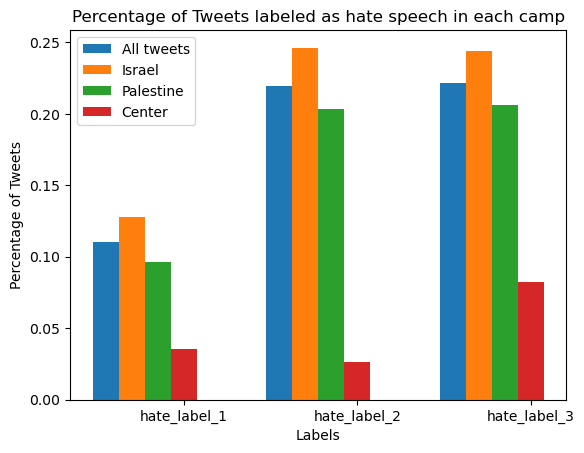

In [12]:
# let's plot the count of labels in each camp

count_a = df[singular_model_hate_speech_labels].apply(sum) / len(df)
count_i = df_i[singular_model_hate_speech_labels].apply(sum) / len(df_i)
count_p = df_p[singular_model_hate_speech_labels].apply(sum) / len(df_p)
count_c = df_c[singular_model_hate_speech_labels].apply(sum)/ len(df_c)
dataframes = [count_a, count_i, count_p, count_c]
labels = ["All tweets","Israel", "Palestine", "Center"]
title = "Percentage of Tweets labeled as hate speech in each camp"
xlabel = "Labels"
ylabel = "Percentage of Tweets"
barplot_multiple_dataframes(dataframes, labels, title, xlabel, ylabel, legend = True)

As said before, these hate speech models might be biased and therefore we should also plot the majority vote and the AND-ing and OR-ing of these results. We'll also add the results of the argument detection model to that plot

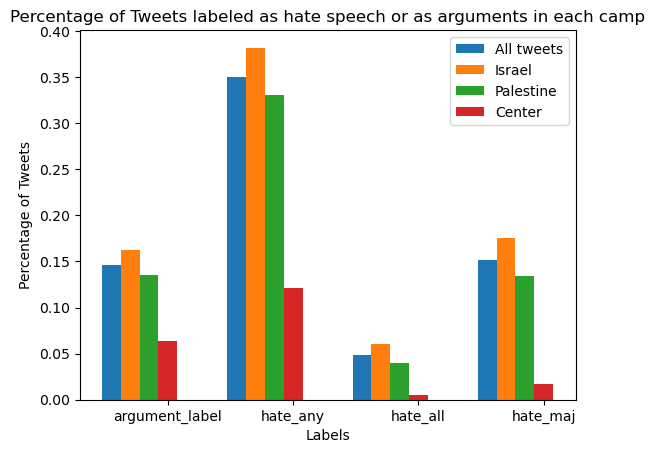

In [13]:
count_a = df[label_cols].apply(sum) / len(df)
count_i = df_i[label_cols].apply(sum) / len(df_i)
count_p = df_p[label_cols].apply(sum) / len(df_p)
count_c = df_c[label_cols].apply(sum)/ len(df_c)
dataframes = [count_a,count_i, count_p, count_c]
labels = ["All tweets", "Israel", "Palestine", "Center"]
title = "Percentage of Tweets labeled as hate speech or as arguments in each camp"
xlabel = "Labels"
ylabel = "Percentage of Tweets"
barplot_multiple_dataframes(dataframes, labels, title, xlabel, ylabel, legend = True)

While we see a difference in the plot in the number of tweets labeled as hate speech, we should make sure that these differences are statistically significant. So let's define a local function that uses our statistcal test functions. 

As expected, we find that the centre camp has a smaller proportion of tweets labeled as hate speech since most of the tweets in that camp are expected to be non-biased. However, this means that we only need to compare the Israeli and Palestinian camps since they are the ones with closer proportions to each other.

In [14]:
def categorical_testing(dataframe1, dataframe2, test_column, alpha):
    print("****** Tesing for Column {} ******".format(test_column))
    chi_square_test(dataframe1[test_column].values, dataframe2[test_column].values,alpha=alpha)
    print("************************************************************")

In [15]:
for col in label_cols + singular_model_hate_speech_labels:
    categorical_testing(df_i, df_p, col, alpha = 0.05)

****** Tesing for Column argument_label ******
p-value: 0.9463782661717143
There is no significant difference between the groups.
************************************************************
****** Tesing for Column hate_any ******
p-value: 0.06870498786976384
There is no significant difference between the groups.
************************************************************
****** Tesing for Column hate_all ******
p-value: 0.5241599243818962
There is no significant difference between the groups.
************************************************************
****** Tesing for Column hate_maj ******
p-value: 0.021167336872349597
There is a significant difference between the groups.
************************************************************
****** Tesing for Column hate_label_1 ******
p-value: 0.6323304057146104
There is no significant difference between the groups.
************************************************************
****** Tesing for Column hate_label_2 ******
p-value: 0.0010964

We see that only columns hate_label 2 and hate_maj are statistically significant at the 0.05 level. Let's also do the same tests using the fisher exact test function to mitigate possible invalidity of test due to low number of values

In [16]:
def categorical_testing_fisher(dataframe1, dataframe2, test_column, alpha):
    print("****** Tesing for Column {} ******".format(test_column))
    fishers_exact_test(dataframe1[test_column].values, dataframe2[test_column].values,alpha=alpha)
    print("************************************************************")

In [17]:
for col in label_cols + singular_model_hate_speech_labels:
    categorical_testing_fisher(df_i, df_p, col, alpha = 0.05)

****** Tesing for Column argument_label ******
p-value: 0.9214540782262869
There is no significant difference between the groups.
************************************************************
****** Tesing for Column hate_any ******
p-value: 0.06832218620857852
There is no significant difference between the groups.
************************************************************
****** Tesing for Column hate_all ******
p-value: 0.5478475283886199
There is no significant difference between the groups.
************************************************************
****** Tesing for Column hate_maj ******
p-value: 0.020010718990196408
There is a significant difference between the groups.
************************************************************
****** Tesing for Column hate_label_1 ******
p-value: 0.6356764961959711
There is no significant difference between the groups.
************************************************************
****** Tesing for Column hate_label_2 ******
p-value: 0.0010281

We find the exact same results as above.


Let's move on for now from the comparison of hate speech labels between the two camps and look into the results of our sentiment analysis model.

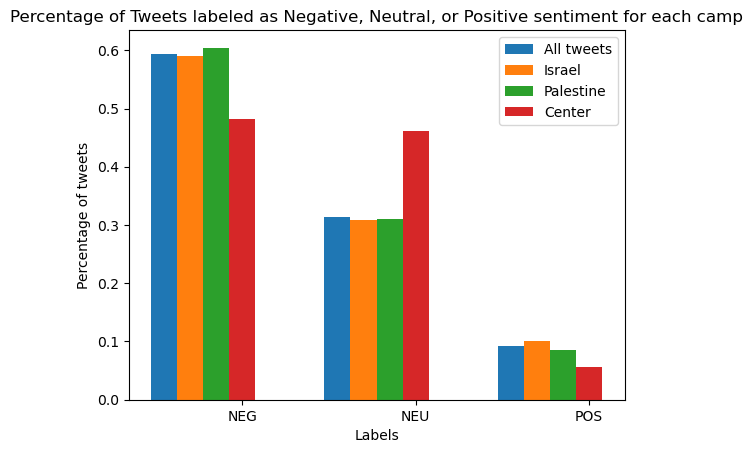

In [18]:
# let's plot the percentage of labels in each camp


count_a = df["sentiment_label"].value_counts() / len(df)
count_i = df_i["sentiment_label"].value_counts() / len(df_i)
count_p = df_p["sentiment_label"].value_counts() / len(df_p)
count_c = df_c["sentiment_label"].value_counts() / len(df_c)
dataframes = [count_a, count_i, count_p, count_c]
labels = ["All tweets","Israel", "Palestine", "Center"]
title = "Percentage of Tweets labeled as Negative, Neutral, or Positive sentiment for each camp"
xlabel = "Labels"
ylabel = "Percentage of tweets"
barplot_multiple_dataframes(dataframes, labels, title, xlabel, ylabel, legend = True)

As expected, we see that the centre camp is mostly neutral, sometimes negative (also expected since they're reporting news about conflict and casualities), and the least positive of all.

We see as well that there is mostly very little differences between the other two camps with the Israeli camp slightly more positive than the Palestinian camp. 

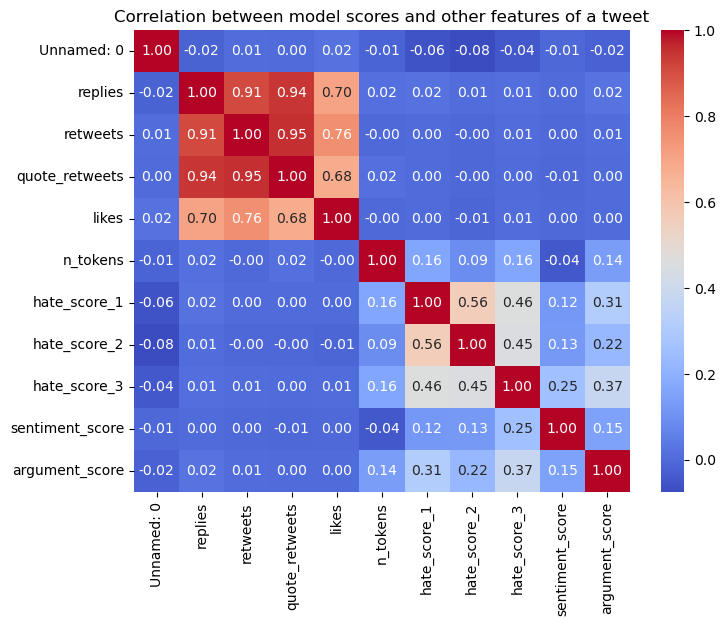

In [19]:
plot_correlation_heatmap(df[numerical_cols],title="Correlation between model scores and other features of a tweet")

We commented on the relationship between like, retweets, quote retweets, and replies on the first notebook.

Here we a mild correlation between the hate scores and one another which makes sense and a smaller positive correlation between these hate scores and the argument score which makes sense as more argumentative statements can be charged with hate or even misunderstood as hate speech.

We see no correlation between hate scores and likes and replies but then again this score is only a confidence score which might not be quite indicative of the relationship. Let's do some statistical analysis to explore the relation between crowd interaction with tweets and the labels of the models.

In [20]:
def pairwise_test_column_based_on_group(df, 
                                        alpha,
                                        column_to_test,
                                        column_to_group_by,
                                        tweets_title = "",
                                        print_results = False
                                    ):
    data = dict(df.dropna(subset=[column_to_test]).groupby(column_to_group_by)[column_to_test].apply(list))
    results = pairwise_t_tests(data, alpha=alpha)
    if print_results:
        for result in results:
            print(results)
    group_means = df.groupby(column_to_group_by)[column_to_test].mean()
    barplot_multiple_dataframes(dataframes = [group_means],
                                 labels = group_means.index.to_list(),
                                 title= "mean of {} for {}".format(column_to_test, tweets_title), 
                                 xlabel= column_to_group_by,
                                 ylabel= "mean of group",
                                 legend=False
    )
 



We'll only focus on likes and replies to save time and to not clutter the notebook. Let's start with sentiment analysis.

groups with significant differences:  ['NEG and NEU']
group wihout signifcant difference:  ['NEG and POS', 'NEU and POS']


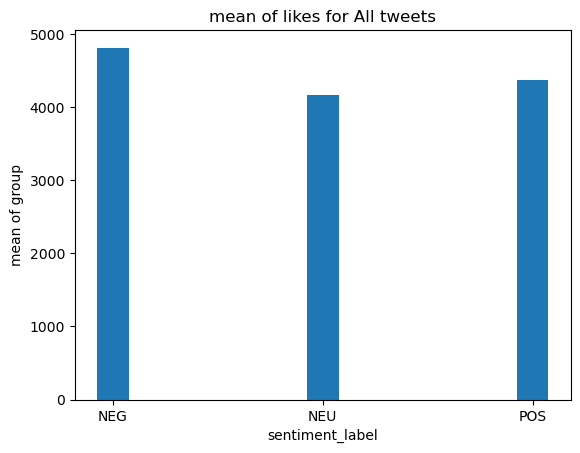

groups with significant differences:  ['NEG and NEU']
group wihout signifcant difference:  ['NEG and POS', 'NEU and POS']


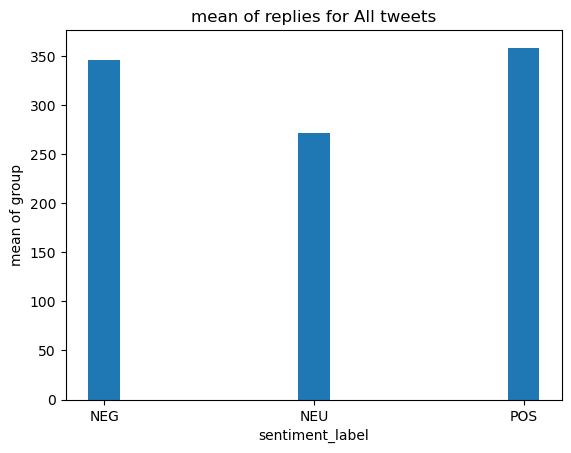

In [21]:
pairwise_test_column_based_on_group(df, 
                                    alpha = 0.05,
                                    column_to_test = "likes",
                                    column_to_group_by = "sentiment_label",
                                    tweets_title = "All tweets",
                                )
pairwise_test_column_based_on_group(df, 
                                    alpha = 0.05,
                                    column_to_test = "replies",
                                    column_to_group_by = "sentiment_label",
                                    tweets_title = "All tweets",
                                )

groups with significant differences:  ['NEG and NEU']
group wihout signifcant difference:  ['NEG and POS', 'NEU and POS']


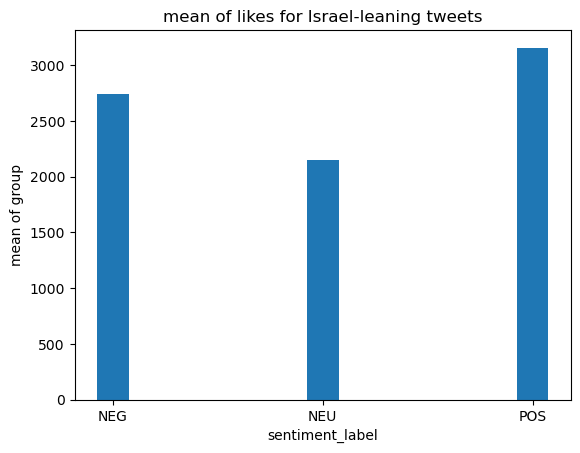

groups with significant differences:  ['NEG and NEU']
group wihout signifcant difference:  ['NEG and POS', 'NEU and POS']


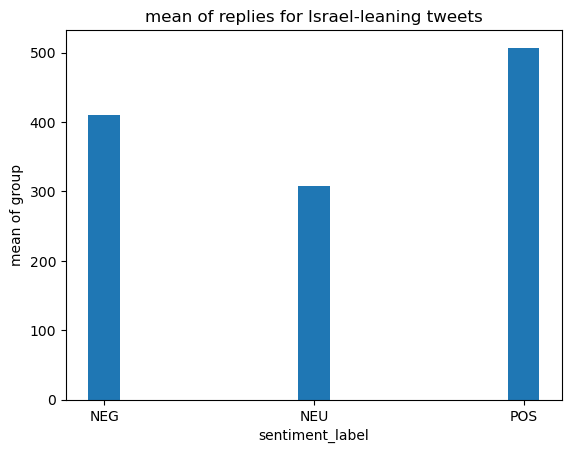

In [22]:
pairwise_test_column_based_on_group(df_i, 
                                    alpha = 0.05,
                                    column_to_test = "likes",
                                    column_to_group_by = "sentiment_label",
                                    tweets_title ="Israel-leaning tweets",
                                )
pairwise_test_column_based_on_group(df_i, 
                                    alpha = 0.05,
                                    column_to_test = "replies",
                                    column_to_group_by = "sentiment_label",
                                    tweets_title = "Israel-leaning tweets",
                                )

groups with significant differences:  ['NEG and NEU', 'NEG and POS']
group wihout signifcant difference:  ['NEU and POS']


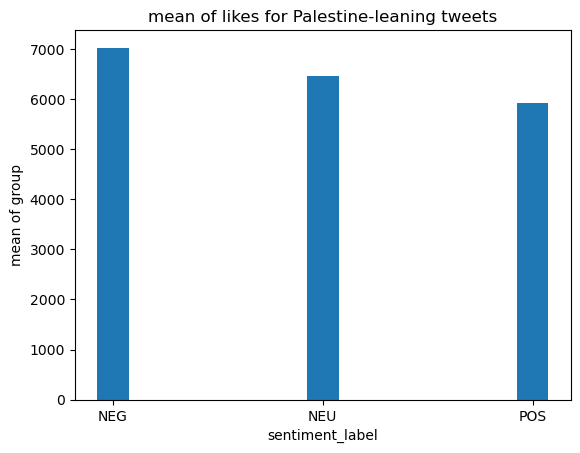

groups with significant differences:  ['NEG and NEU', 'NEG and POS', 'NEU and POS']
group wihout signifcant difference:  []


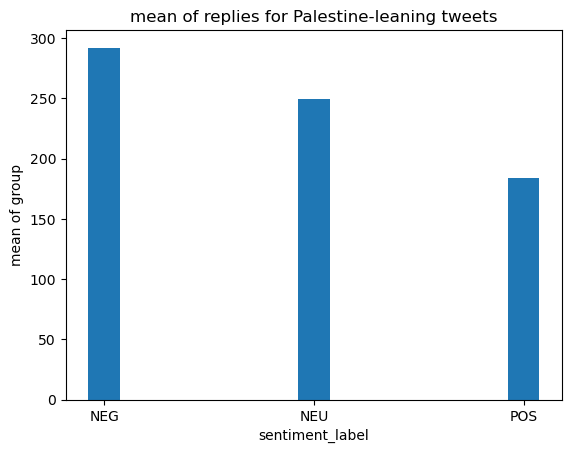

In [23]:
pairwise_test_column_based_on_group(df_p, 
                                    alpha = 0.05,
                                    column_to_test = "likes",
                                    column_to_group_by = "sentiment_label",
                                    tweets_title ="Palestine-leaning tweets",
                                )
pairwise_test_column_based_on_group(df_p, 
                                    alpha = 0.05,
                                    column_to_test = "replies",
                                    column_to_group_by = "sentiment_label",
                                    tweets_title = "Palestine-leaning tweets",
                                )

groups with significant differences:  []
group wihout signifcant difference:  ['NEG and NEU', 'NEG and POS', 'NEU and POS']


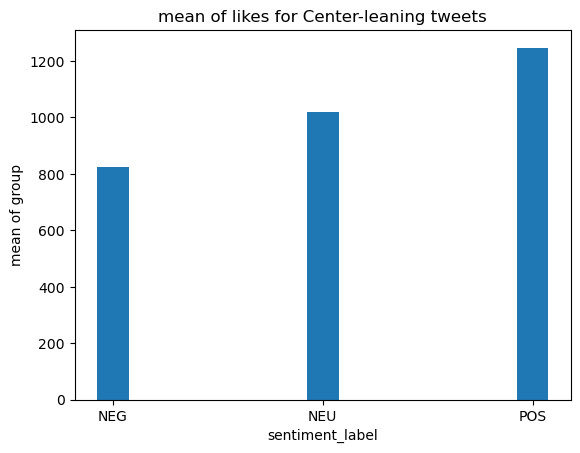

groups with significant differences:  []
group wihout signifcant difference:  ['NEG and NEU', 'NEG and POS', 'NEU and POS']


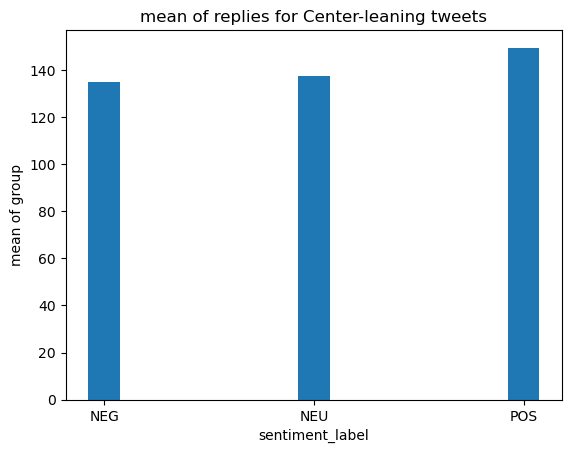

In [24]:
pairwise_test_column_based_on_group(df_c, 
                                    alpha = 0.05,
                                    column_to_test = "likes",
                                    column_to_group_by = "sentiment_label",
                                    tweets_title ="Center-leaning tweets",
                                )
pairwise_test_column_based_on_group(df_c, 
                                    alpha = 0.05,
                                    column_to_test = "replies",
                                    column_to_group_by = "sentiment_label",
                                    tweets_title = "Center-leaning tweets",
                                )

From the above results we can see that for the Israeli-leaning tweets, positive tweets are more likely to get traction, while for Palestinian-leaning tweets, negative tweets are more likely to get traction. However, the difference that is most likely to be statistically significant is between negative and neutral tweets. Also, as a general trend, neutral tweets are less likely to get traction.

For the centre-leaning tweets, none of these differences are statistically significant.

Let's do the same thing but for the majority-voted hate speech tweets.

groups with significant differences:  ['False and True']
group wihout signifcant difference:  []


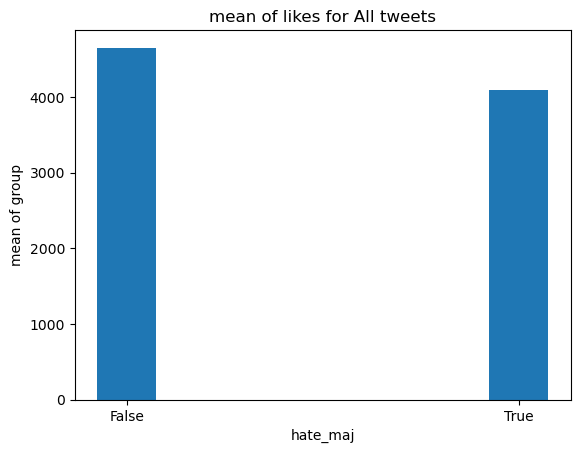

groups with significant differences:  ['False and True']
group wihout signifcant difference:  []


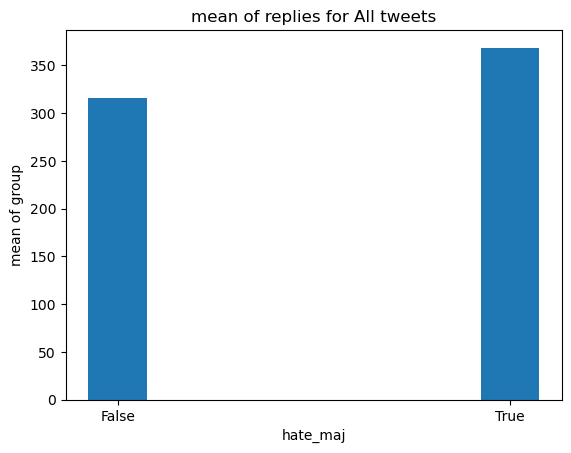

In [25]:
pairwise_test_column_based_on_group(df, 
                                    alpha = 0.05,
                                    column_to_test = "likes",
                                    column_to_group_by = "hate_maj",
                                    tweets_title ="All tweets",
                                )
pairwise_test_column_based_on_group(df, 
                                    alpha = 0.05,
                                    column_to_test = "replies",
                                    column_to_group_by = "hate_maj",
                                    tweets_title = "All tweets",
                                )

groups with significant differences:  []
group wihout signifcant difference:  ['False and True']


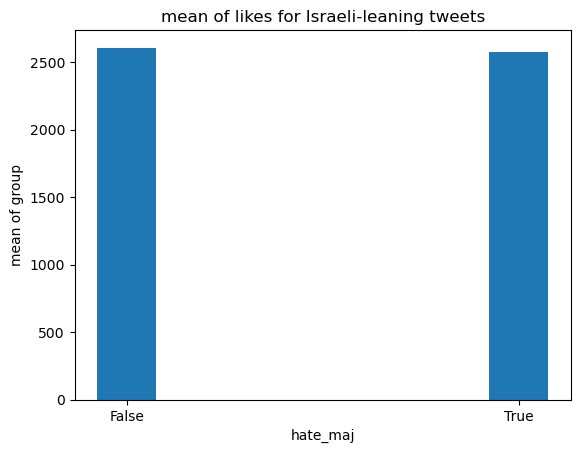

groups with significant differences:  ['False and True']
group wihout signifcant difference:  []


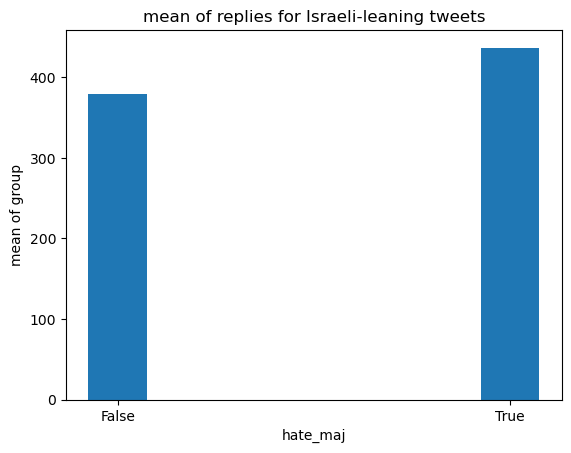

In [26]:
pairwise_test_column_based_on_group(df_i, 
                                    alpha = 0.05,
                                    column_to_test = "likes",
                                    column_to_group_by = "hate_maj",
                                    tweets_title ="Israeli-leaning tweets",
                                )
pairwise_test_column_based_on_group(df_i, 
                                    alpha = 0.05,
                                    column_to_test = "replies",
                                    column_to_group_by = "hate_maj",
                                    tweets_title = "Israeli-leaning tweets",
                                )

groups with significant differences:  ['False and True']
group wihout signifcant difference:  []


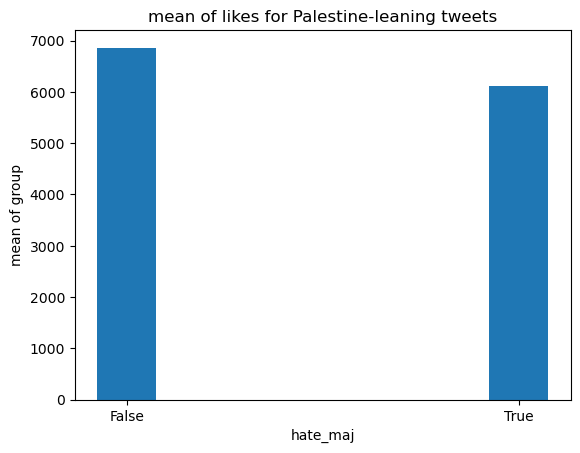

groups with significant differences:  []
group wihout signifcant difference:  ['False and True']


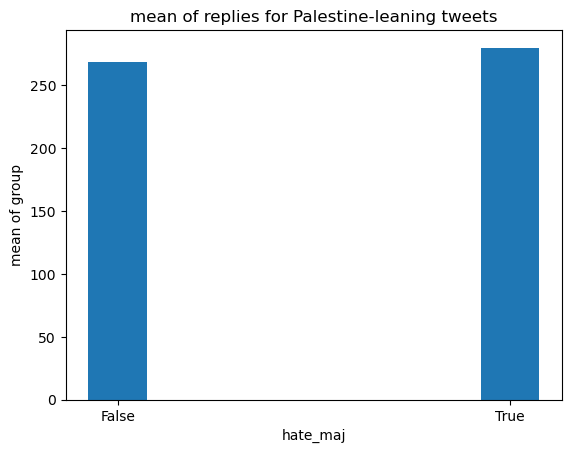

In [27]:
pairwise_test_column_based_on_group(df_p, 
                                    alpha = 0.05,
                                    column_to_test = "likes",
                                    column_to_group_by = "hate_maj",
                                    tweets_title ="Palestine-leaning tweets",
                                )
pairwise_test_column_based_on_group(df_p, 
                                    alpha = 0.05,
                                    column_to_test = "replies",
                                    column_to_group_by = "hate_maj",
                                    tweets_title = "Palestine-leaning tweets",
                                )

groups with significant differences:  []
group wihout signifcant difference:  ['False and True']


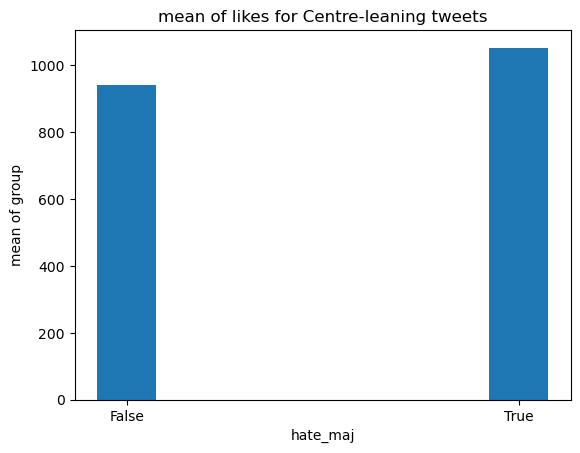

groups with significant differences:  []
group wihout signifcant difference:  ['False and True']


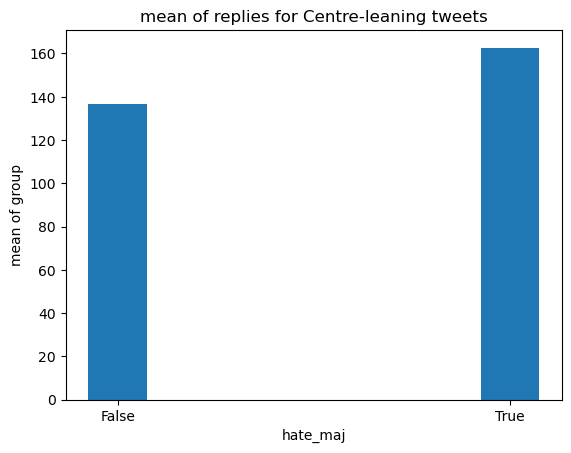

In [28]:
pairwise_test_column_based_on_group(df_c, 
                                    alpha = 0.05,
                                    column_to_test = "likes",
                                    column_to_group_by = "hate_maj",
                                    tweets_title ="Centre-leaning tweets",
                                )
pairwise_test_column_based_on_group(df_c, 
                                    alpha = 0.05,
                                    column_to_test = "replies",
                                    column_to_group_by = "hate_maj",
                                    tweets_title = "Centre-leaning tweets",
                                )

Looking at the above results we see that the statiscally signficant differences are:
- For the Israeli-leaning tweets, tweets that are labeled as hate speech are more likely to get more replies
- for the Palestinian-leaning tweets, tweets that are labeled as non-hate speech are more likely to get more likes
- For all tweets, hateful tweets are more likely to get more replies while non-hate tweets are more likely to get more likes

Other than the above, results are insignificant

Let's check how the hate speech is divided amoung users on both camps

In [29]:
# retrieve users alongside the number of their tweets cited as hateful tweets
df_hate_users=df.groupby("username")[["hate_maj"]].sum(numeric_only=True).sort_values(by="hate_maj", ascending=False)
# find number of tweets for each user
df_hate_users["no_of_tweets"] = df["username"].value_counts()
# find proportion of hateful tweets to total tweets for each user
df_hate_users["hate_percentage"] = df_hate_users["hate_maj"]/df_hate_users["no_of_tweets"]
# retrieve the leaning for each of these users
df_hate_users["leaning"]=df.groupby("username")["leaning"].unique().apply(lambda x: x[0])
df_hate_users.sort_values(by="hate_maj", ascending=False).head(20)

,hate_maj,no_of_tweets,hate_percentage,leaning
username,,,,
@DefundIsraelNow,357,911,0.391877,palestine
@JonnyFX1,294,1285,0.228794,palestine
@mishtal,254,701,0.362340,israel
@TorahJudaism,229,423,0.541371,palestine
@AdamAlbilya,221,991,0.223007,israel
@realstewpeters,203,890,0.228090,palestine
@richimedhurst,201,596,0.337248,palestine
@CherylE59628,186,441,0.421769,israel
@leeonskee,183,1216,0.150493,israel


In [30]:
# return the top 20 users (with at least 30 tweets) according to their hate speech percentage.
df_hate_users.sort_values(by="hate_percentage", ascending=False)[df_hate_users["no_of_tweets"]>30].head(20)

,hate_maj,no_of_tweets,hate_percentage,leaning
username,,,,
@leekern13,96,167,0.574850,israel
@TorahJudaism,229,423,0.541371,palestine
@JustLuai,132,290,0.455172,israel
@dani86873,25,56,0.446429,israel
@CherylE59628,186,441,0.421769,israel
@agelender,13,31,0.419355,palestine
@DefundIsraelNow,357,911,0.391877,palestine
@realMaalouf,152,390,0.389744,israel
@mishtal,254,701,0.362340,israel


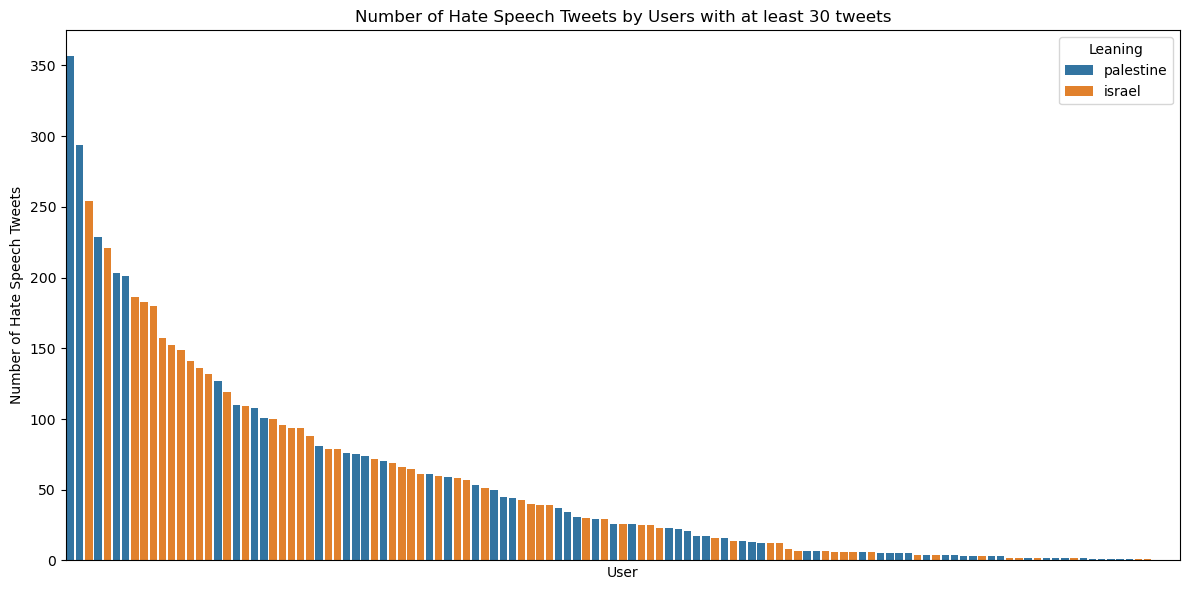

In [31]:
bar_plot_many_datapoints(
    df = df_hate_users[df_hate_users["no_of_tweets"]>30],
    x_column="username",
    y_column = "hate_maj",
    hue= "leaning",
    x_label="User",
    y_label="Number of Hate Speech Tweets",
    title="Number of Hate Speech Tweets by Users with at least 30 tweets",
    legend_title="Leaning"
)
   
    

We need to account however for the total number of tweets each of these users post. Therefore, a proportion of hate speech tweets would be also valuable. So let's check the next plot.

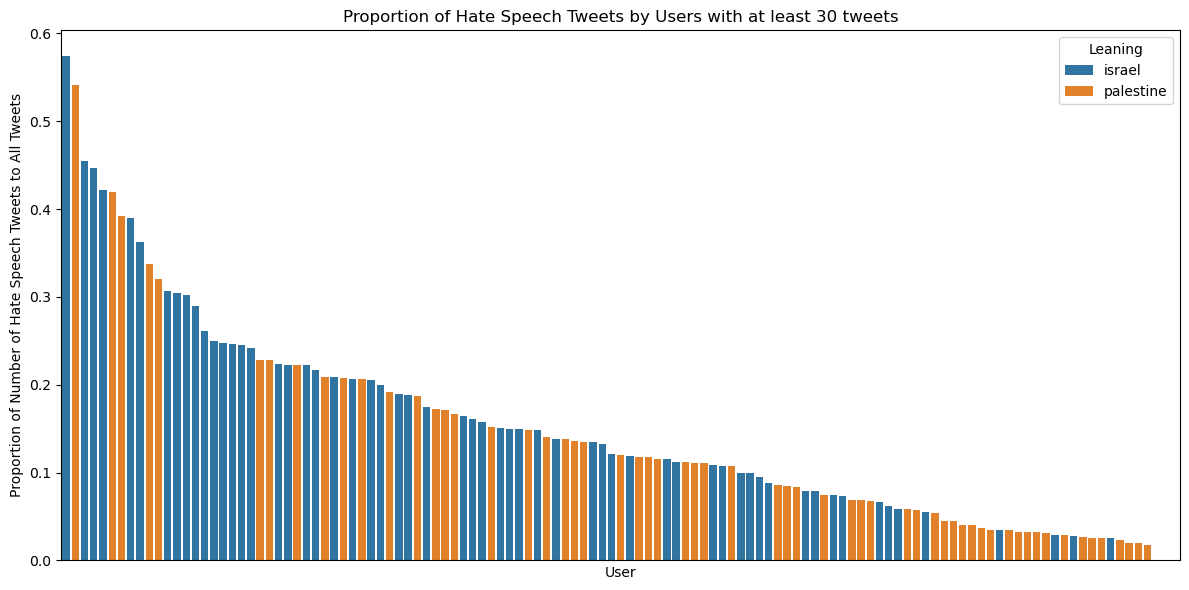

In [32]:
bar_plot_many_datapoints(
    df = df_hate_users[df_hate_users["no_of_tweets"]>30].sort_values(by="hate_percentage", ascending=False),
    x_column="username",
    y_column = 'hate_percentage',
    hue= "leaning",
    x_label="User",
    y_label='Proportion of Number of Hate Speech Tweets to All Tweets',
    title='Proportion of Hate Speech Tweets by Users with at least 30 tweets',
    legend_title="Leaning"
)



In [33]:
I_users = df_hate_users[df_hate_users["no_of_tweets"]>30][df_hate_users["leaning"] == "israel"]
P_users = df_hate_users[df_hate_users["no_of_tweets"]>30][df_hate_users["leaning"] == "palestine"]

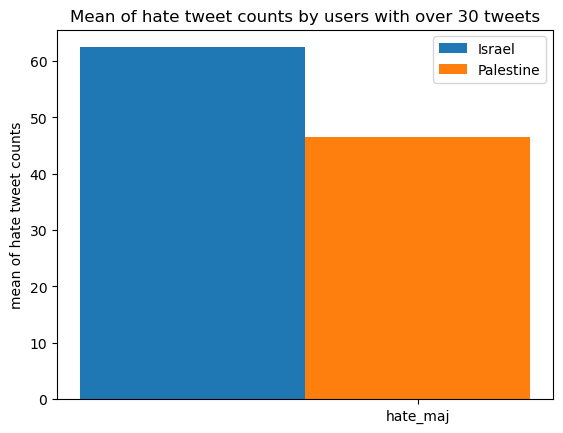

In [34]:

means = [I_users[["hate_maj"]].mean(), P_users[["hate_maj"]].mean()]
barplot_multiple_dataframes(dataframes = means,
                                labels = ["Israel", "Palestine"],
                                title= "Mean of hate tweet counts by users with over 30 tweets", 
                                xlabel= "",
                                ylabel= "mean of hate tweet counts",
                                legend=True
)




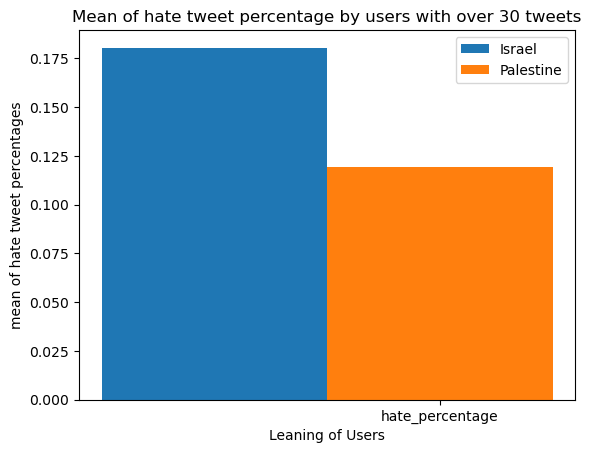

In [35]:

means = [I_users[["hate_percentage"]].mean(), P_users[["hate_percentage"]].mean()]
barplot_multiple_dataframes(dataframes = means,
                                labels = ["Israel", "Palestine"],
                                title= "Mean of hate tweet percentage by users with over 30 tweets", 
                                xlabel= "Leaning of Users",
                                ylabel= "mean of hate tweet percentages",
                                legend=True
)




We can see that more Israel-leaning users are shown on this list with higher mean of hate speech tweets count and percentage. Let's see if that difference is significant using Mann-Whitney U test (or Wilcoxon rank-sum test).

In [36]:
paired_mannwhitneyu_rank_test(
    sample1 = I_users.hate_maj.values,
    sample2 = P_users.hate_maj.values,
    alpha = 0.05
    )

Mann-Whitney U statistic: 2265.5
p-value: 0.024062534674017533
Reject the null hypothesis. There is a significant difference between the paired samples.


In [37]:
paired_mannwhitneyu_rank_test(
    sample1 = I_users.hate_percentage.values,
    sample2 = P_users.hate_percentage.values,
    alpha = 0.05
    )

Mann-Whitney U statistic: 2489.5
p-value: 0.0006346286177689547
Reject the null hypothesis. There is a significant difference between the paired samples.


It appears that there is a significant difference between the two groups.